In [1]:
import os,json
import sys
import augur
import sqlalchemy as s
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plot
import matplotlib.dates as mdates
import datetime as dt
#!{sys.executable} -m pip install sklearn
#!{sys.executable} -m pip install xlrd
#!{sys.executable} -m pip install imblearn

In [2]:
if("notebooks" in os.getcwd()):
    os.chdir("../SentiCR")
    from SentiCR.SentiCR import SentiCR

sentiment_analyzer = SentiCR()

if("notebooks" not in os.getcwd()):
    os.chdir("../../notebooks")
augurApp = augur.Application('../augur.config.json')
connect,list1,path = augurApp.github_issues()
DB_STR = 'mysql+pymysql://{}:{}@{}:{}/{}?charset=utf8'.format(
            list1[0], list1[1], list1[2],\
            list1[3], list1[4]
        )
db = s.create_engine(DB_STR)

table_names = s.inspect(db).get_table_names()
print(table_names)

if("github_pull_requests_2" in table_names):
    lists_createdSQL = s.sql.text("""SELECT repo FROM github_pull_requests_2""")
    df1 = pd.read_sql(lists_createdSQL, db)
    #print(df1)
    val = True

col = 'score','sentiment'

SQL = """SELECT * FROM github_pull_requests_2"""
df_users =  pd.read_sql(SQL, db)
print(df_users.head())
print(df_users.tail())

/home/keanu/temp/augur_push/augur5/augur/SentiCR
/home/keanu/temp/augur_push/augur5/augur/SentiCR/SentiCR
Reading data from oracle..
Training classifier model..


/home/keanu/anaconda3/envs/augur/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


['github_issues', 'github_issues_2', 'github_issues_repo_jobs', 'github_issues_sentiment_scores', 'github_issues_sentiment_scores_senticr', 'github_pull_request_repo_jobs', 'github_pull_requests', 'github_pull_requests_2', 'github_pull_requests_sentiment_scores', 'github_pull_requests_sentiment_scores_2', 'issue_response_time', 'mail_lists', 'mail_lists_sentiment_scores', 'mail_lists_sentiment_scores_senticr', 'mailing_list_jobs']
   augurmsgID backend_name                                     repo_link  \
0           1       GitHub  https://github.com/OSSHealth/ResearchProject   
1           2       GitHub  https://github.com/OSSHealth/ResearchProject   
2           3       GitHub  https://github.com/OSSHealth/ResearchProject   
3           4       GitHub  https://github.com/OSSHealth/ResearchProject   
4           5       GitHub  https://github.com/OSSHealth/ResearchProject   

       owner             repo  \
0  OSSHealth  ResearchProject   
1  OSSHealth  ResearchProject   
2  OSSHea

In [3]:
grouped = df_users.groupby('subject').groups
num = 0
col = 'score','sentiment'
columns1 = 'augurmsgID',"backend_name",'repo_link',"owner","repo","subject",\
          "status","category","pull_request_number","date",\
          "pull_request_id","user","body"
df3 = pd.DataFrame(columns=col)
df_list = pd.DataFrame(columns = columns1)
df_list = df_list.append(df_users)
for group in grouped:
    #print(group)
    issue_num = (df_users.loc[df_users['subject'] == group]['pull_request_number']).values
    messages = (df_users.loc[df_users['subject'] == group]['body']).tolist()
    id1 = (df_users.loc[df_users['subject'] == group]['body']).tolist()
    #print("Issue number: ",issue_num[0])
    #break
    for i in messages:
        #print(i)
        score=sentiment_analyzer.get_sentiment_polarity(i)
        score = int(score[0])
        compound = parts = 0
        sentiment = "Positive"
        if(score == -1):
            sentiment = "Negative"
        li = [ [score,sentiment]]
        df_temp = pd.DataFrame(li,columns=col)
        df3 = df3.append(df_temp)
        #if(avg < -0.5):
            #print(i,avg)
            #print("\n\n\n\n\n\n")
    #if(num == 40):
    #    break
    num+=1
    #print("\n\n\n")
print(num)

10


In [4]:
#print(df3)
#print(df_list)
df3 = df3.reset_index(drop=True)
#print(df3.head())
df_list = df_list.reset_index(drop=True)
combine = (df_list.join(df3))

print(combine.head())

combine.to_sql(name='github_pull_requests_sentiment_scores_senticr',\
               con=db,if_exists='replace',index=False)

  augurmsgID backend_name                                     repo_link  \
0          1       GitHub  https://github.com/OSSHealth/ResearchProject   
1          2       GitHub  https://github.com/OSSHealth/ResearchProject   
2          3       GitHub  https://github.com/OSSHealth/ResearchProject   
3          4       GitHub  https://github.com/OSSHealth/ResearchProject   
4          5       GitHub  https://github.com/OSSHealth/ResearchProject   

       owner             repo  \
0  OSSHealth  ResearchProject   
1  OSSHealth  ResearchProject   
2  OSSHealth  ResearchProject   
3  OSSHealth  ResearchProject   
4  OSSHealth  ResearchProject   

                                             subject  status      category  \
0                            Consolidated Indicators  closed  pull_request   
1  Added broad categories, bolded indicators that...  closed  pull_request   
2             added indicators and ideas from LFOSLS  closed  pull_request   
3             added indicators and ide

(6,)
(6,)


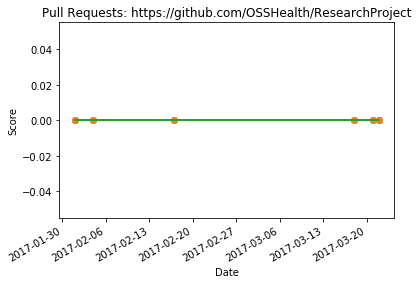

(4,)
(4,)


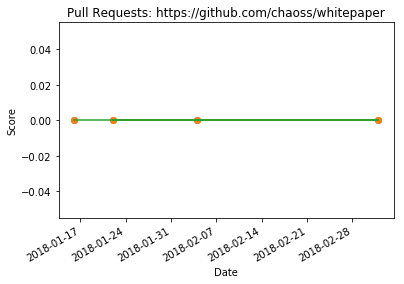

In [5]:
repos = combine.groupby('repo_link')
x = 0
for repo in repos:
    fin_dates = []
    fin_values = []
    dates = []
    values = []
    mail_list = None
    j = 0
    rep = (combine.loc[combine['repo_link'] == repo[0]])
    grouped = rep.groupby('subject').groups
    for group in grouped:
        #print(group)
        dates = (combine.loc[combine['subject'] == group]['date']).tolist()
        values = []
        for val in dates:
            #print(val)
            values.append((combine.loc[combine['date'] == val]['score']).tolist()[0])
        #print("Issue number: ",issue_num[0])
        x = np.array(dates)
        x = [str(k) for k in x]
        dates = [dt.datetime.strptime(d[:10],'%Y-%m-%d').date() for d in x]
        dates1 = [x for x in dates]
        values = sum(values[0:len(values)])/len(values)
        if(values >= -0.5):
            values = 0
        else:
            values = -1
        fin_dates.append(dates1[0])
        fin_values.append(values)
        num+=1
        j+=1
    fin_dates = mdates.date2num(fin_dates)
    fin_values = np.asarray(fin_values)
    print(fin_dates.shape)
    print(fin_values.shape)
    plot.plot_date(fin_dates, fin_values)
    #plot.plot(fin_dates,fin_values)
    plot.gcf().autofmt_xdate()
    plot.title("Pull Requests: "+ str(repo[0]))
    plot.ylabel('Score')
    plot.xlabel('Date')
    #print(fin_dates)
    slope, intercept, r_value, p_value, std_err = stats.linregress(fin_dates,fin_values)
    line = slope*fin_dates+intercept
    plot.plot(fin_dates,fin_values,'o', fin_dates, line)
    #plot.savefig('foo' + str(x) + '.png')
    #x+=1
    plot.show()